# Importing Requisite Libraries

In [73]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Reading the Data

In [2]:
with open('/kaggle/input/nlp-specialization-data/Novel - Moby-Dick By Herman Melville.txt', 'r') as file:
    text = file.read()

In [3]:
# Previewing the data
text[:1000]

"CHAPTER 1\n\nLoomings.\n\n\nCall me Ishmael.  Some years ago--never mind how long\nprecisely--having little or no money in my purse, and nothing\nparticular to interest me on shore, I thought I would sail about a\nlittle and see the watery part of the world.  It is a way I have of\ndriving off the spleen and regulating the circulation.  Whenever I\nfind myself growing grim about the mouth; whenever it is a damp,\ndrizzly November in my soul; whenever I find myself involuntarily\npausing before coffin warehouses, and bringing up the rear of every\nfuneral I meet; and especially whenever my hypos get such an upper\nhand of me, that it requires a strong moral principle to prevent me\nfrom deliberately stepping into the street, and methodically knocking\npeople's hats off--then, I account it high time to get to sea as soon\nas I can.  This is my substitute for pistol and ball.  With a\nphilosophical flourish Cato throws himself upon his sword; I quietly\ntake to the ship.  There is nothin

# Preprocessing and EDA

## Tokenizing the text

In [4]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1
total_words

17401

In [5]:
# print(tokenizer.word_index)

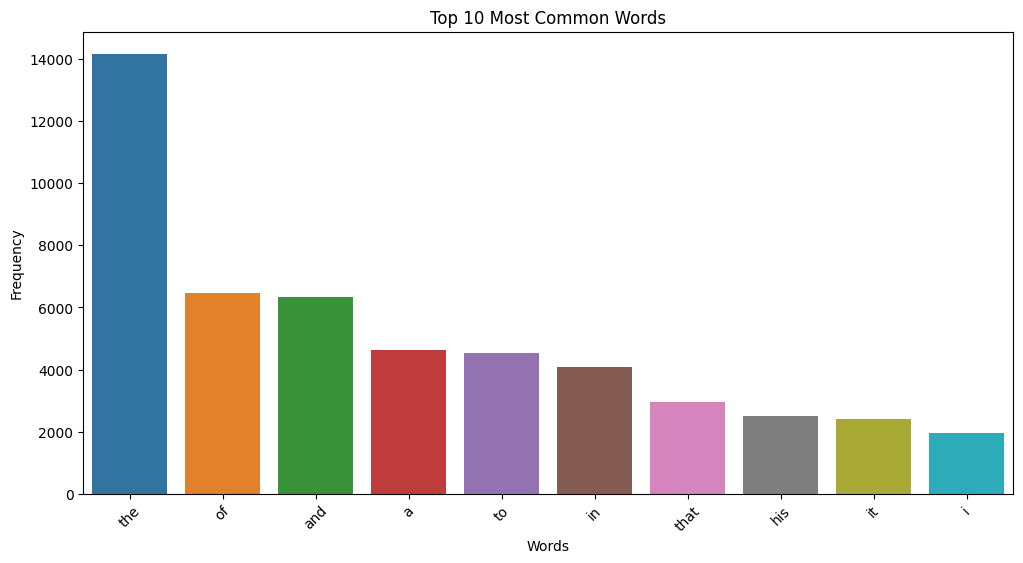

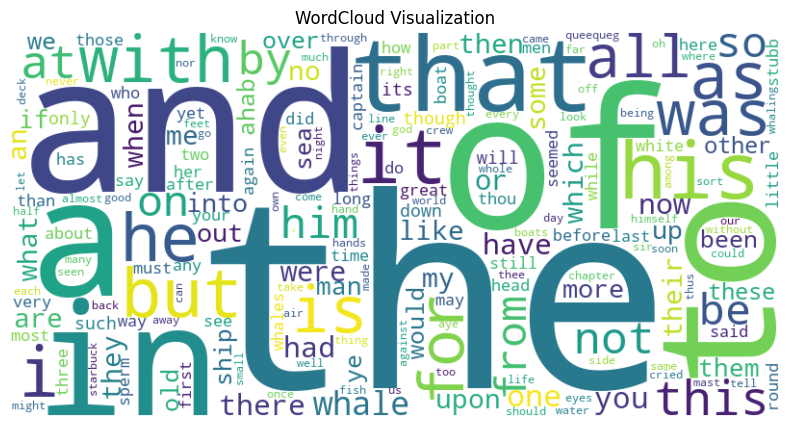

In [74]:
# Bar graph showing the word frequencies
word_counts = tokenizer.word_counts
common_words = [word for word in word_counts.keys()]
common_counts = [count for count in word_counts.values()]

# Sort words by frequency
sorted_indices = np.argsort(common_counts)[::-1]
common_words = np.array(common_words)[sorted_indices]
common_counts = np.array(common_counts)[sorted_indices]

# top 10 most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=common_words[:10], y=common_counts[:10])
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

## Creating an input sequence

In [6]:
# Create input sequences and labels
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [7]:
len(input_sequences)

193429

## Padding the sequence based on the largest sequence

In [10]:
# Pad sequences
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

In [11]:
# Create predictors and labels
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = np.expand_dims(label, axis=-1)

# Model Building

In [14]:
# Build the Bi-Directional LSTM model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length - 1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.01))

# Model Training

In [15]:
# Train the model
model.fit(predictors, label, epochs=10, verbose=1)

Epoch 1/10
6045/6045 [==============================] - 71s 11ms/step - loss: 6.8259
Epoch 2/10
6045/6045 [==============================] - 55s 9ms/step - loss: 6.3134
Epoch 3/10
6045/6045 [==============================] - 53s 9ms/step - loss: 6.0595
Epoch 4/10
6045/6045 [==============================] - 53s 9ms/step - loss: 5.8453
Epoch 5/10
6045/6045 [==============================] - 53s 9ms/step - loss: 5.6466
Epoch 6/10
6045/6045 [==============================] - 52s 9ms/step - loss: 5.4559
Epoch 7/10
6045/6045 [==============================] - 51s 8ms/step - loss: 5.2782
Epoch 8/10
6045/6045 [==============================] - 52s 9ms/step - loss: 5.1101
Epoch 9/10
6045/6045 [==============================] - 52s 9ms/step - loss: 4.9490
Epoch 10/10
6045/6045 [==============================] - 52s 9ms/step - loss: 4.7979


In [16]:
# Save the model to a file
model.save('bi_directional_lstm_model.h5')
print("Model saved successfully.")

Model saved successfully.


# Function for Generating Next Words Using Trained Model

In [42]:
def generate_next_words(seed_text, num_words=1):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length - 1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generating Texts

In [65]:
# Generate predictions and analyze the findings
total_text1 = []
for num_words in range(1,10):
    seed_text = "Call me Ishmael"
    generated_text = generate_next_words(seed_text, num_words)
    print(f"Predicted next {num_words} word(s) after '{seed_text}': {generated_text}")
    total_text1.append(generated_text)

1/1 [==============================] - 0s 21ms/step
Predicted next 1 word(s) after 'Call me Ishmael': Call me Ishmael and
1/1 [==============================] - 0s 22ms/step
Predicted next 2 word(s) after 'Call me Ishmael': Call me Ishmael and the
1/1 [==============================] - 0s 22ms/step
Predicted next 3 word(s) after 'Call me Ishmael': Call me Ishmael and the ship
1/1 [==============================] - 0s 22ms/step
Predicted next 4 word(s) after 'Call me Ishmael': Call me Ishmael and the ship was
1/1 [==============================] - 0s 23ms/step
Predicted next 5 word(s) after 'Call me Ishmael': Call me Ishmael and the ship was not
1/1 [==============================] - 0s 21ms/step
Predicted next 6 word(s) after 'Call me Ishmael': Call me Ishmael and the ship was not the
1/1 [==============================] - 0s 23ms/step
Predicted next 7 word(s) after 'Call me Ishmael': Call me Ishmael and the ship was not the whale
1/1 [==============================] - 0s 23ms/step
Pre

In [66]:
def show_all_text(total_text):
    print(f"Generated texts: \n")
    for sent in total_text:
        print(sent)

In [67]:
total_text2 = []
for num_words in range(1,10):
    seed_text = "Dark times"
    generated_text = generate_next_words(seed_text, num_words)
    print(f"Predicted next {num_words} word(s) after '{seed_text}': {generated_text}")
    total_text2.append(generated_text)

1/1 [==============================] - 0s 20ms/step
Predicted next 1 word(s) after 'Dark times': Dark times of
1/1 [==============================] - 0s 22ms/step
Predicted next 2 word(s) after 'Dark times': Dark times of the
1/1 [==============================] - 0s 22ms/step
Predicted next 3 word(s) after 'Dark times': Dark times of the whale
1/1 [==============================] - 0s 21ms/step
Predicted next 4 word(s) after 'Dark times': Dark times of the whale the
1/1 [==============================] - 0s 23ms/step
Predicted next 5 word(s) after 'Dark times': Dark times of the whale the boats
1/1 [==============================] - 0s 21ms/step
Predicted next 6 word(s) after 'Dark times': Dark times of the whale the boats is
1/1 [==============================] - 0s 22ms/step
Predicted next 7 word(s) after 'Dark times': Dark times of the whale the boats is a
1/1 [==============================] - 0s 22ms/step
Predicted next 8 word(s) after 'Dark times': Dark times of the whale the bo

In [68]:
total_text3 = []
for num_words in range(1,10):
    seed_text = "beauty"
    generated_text = generate_next_words(seed_text, num_words)
    print(f"Predicted next {num_words} word(s) after '{seed_text}': {generated_text}")
    total_text3.append(generated_text)

1/1 [==============================] - 0s 20ms/step
Predicted next 1 word(s) after 'beauty': beauty and
1/1 [==============================] - 0s 22ms/step
Predicted next 2 word(s) after 'beauty': beauty and queens
1/1 [==============================] - 0s 20ms/step
Predicted next 3 word(s) after 'beauty': beauty and queens with
1/1 [==============================] - 0s 21ms/step
Predicted next 4 word(s) after 'beauty': beauty and queens with the
1/1 [==============================] - 0s 21ms/step
Predicted next 5 word(s) after 'beauty': beauty and queens with the other
1/1 [==============================] - 0s 35ms/step
Predicted next 6 word(s) after 'beauty': beauty and queens with the other side
1/1 [==============================] - 0s 23ms/step
Predicted next 7 word(s) after 'beauty': beauty and queens with the other side of
1/1 [==============================] - 0s 21ms/step
Predicted next 8 word(s) after 'beauty': beauty and queens with the other side of the
1/1 [===============

In [69]:
show_all_text(total_text1)
print('\n')
show_all_text(total_text2)
print('\n')
show_all_text(total_text3)

Generated texts: 

Call me Ishmael and
Call me Ishmael and the
Call me Ishmael and the ship
Call me Ishmael and the ship was
Call me Ishmael and the ship was not
Call me Ishmael and the ship was not the
Call me Ishmael and the ship was not the whale
Call me Ishmael and the ship was not the whale is
Call me Ishmael and the ship was not the whale is the


Generated texts: 

Dark times of
Dark times of the
Dark times of the whale
Dark times of the whale the
Dark times of the whale the boats
Dark times of the whale the boats is
Dark times of the whale the boats is a
Dark times of the whale the boats is a very
Dark times of the whale the boats is a very picturesque


Generated texts: 

beauty and
beauty and queens
beauty and queens with
beauty and queens with the
beauty and queens with the other
beauty and queens with the other side
beauty and queens with the other side of
beauty and queens with the other side of the
beauty and queens with the other side of the whale


# Conclusion

The smooth transition and logical progression in the generated texts suggest that the bidirectional LSTM model was able to effectively learn the patterns and contexts from the input data, allowing it to generate text that follows a coherent theme.

As the word "whale" appeared frequently in the corpus, the model might have learned to associate this word with the context it is generating. Hence, we notice the word whale often being used.